# Contents <a id='top'></a>

1. <a href=#intro>Introduction</a>
1. <a href=#img-proc>Image Processing</a>
1. <a href=#obj-det>Object Detection</a>
1. <a href=#ref>References and Links</a>

<a id='intro'></a>
# 1. Introduction
<a href=#top>(back to top)</a>

Data science has a number of applications in computer vision. These have increased in number and accuray in the past 5 years or so due to the advancements in deep learning (both theory and computational feasibility). In this topic, we shall experiment with some of the applications, utilising existing deep learning models.

Here is a short list of applications of computer vision techniques:

1. Optical Character Recognition: Reading handwritten documents, car license plate numbers from images.
2. Surveillance and traffic monitoring: Monitoring cars on a highway, tracking humans in security cameras for suspicious activity.
3. Machine inspection: Automatically detecting damage on components manufactured, such as silicon wafers, etc.

[Here](https://www.cs.ubc.ca/~lowe/vision.html) is an old page with a more comprehensive list of applications.

In computer vision, the goal is to get a computer to perceive the world as *we* see it. This is not easy even for us to do&mdash;we can get fooled by optical illusions such as the ones below.

<img src="../figs/Mueller-Lyer-illusion.png" style="width: 250px;"/><img src="../figs/shadow-illusion3.png" style="width: 500px;"/>

In general though, for us, it is possible to do things like pick out faces that we recognise from a photograph of a crowd. But how can we get a computer to do it? 

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
%matplotlib widget

For interactive plotting in JupyterLab, you will need to install ipympl (e.g., pip install ipympl). You will probably have to restart JupyterLab to get widget to work. (Restarting the kernel is not sufficient.)

For interactive plotting in Jupyter Notebook, replace widget by notebook.

<a id='img-proc'></a>
# 2. Image Processing
<a href=#top>(back to top)</a>

For the next few sections, let us focus on a set of images of sea-grass, taken from St. John's island by students, as part of a fieldwork trip. Several photographs of randomly sampled sections of the beach were taken. Here are some of the photos:

In [2]:
p = Path('../data/seagrass/')

In [3]:
%matplotlib inline

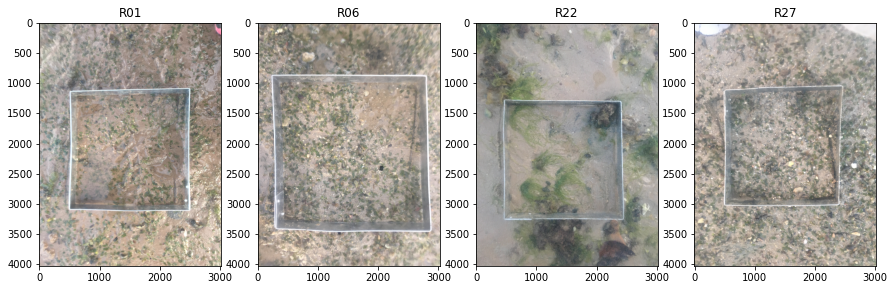

In [4]:
fig, ax = plt.subplots(1, 4)
for i, f in enumerate(p.iterdir()):
    #print(f)
    I = cv.imread(str(f))
    #In the case of color images, the decoded images will have the channels stored in **B G R** order.
    I_RGB = cv.cvtColor(I, cv.COLOR_BGR2RGB)
    if I_RGB.shape[1] > I_RGB.shape[0]:
        I_RGB = I_RGB.swapaxes(0, 1)
    ax[i].imshow(I_RGB);
    ax[i].set_title(str(f.stem))

fig.set_size_inches((15, 5))

In [5]:
%matplotlib widget

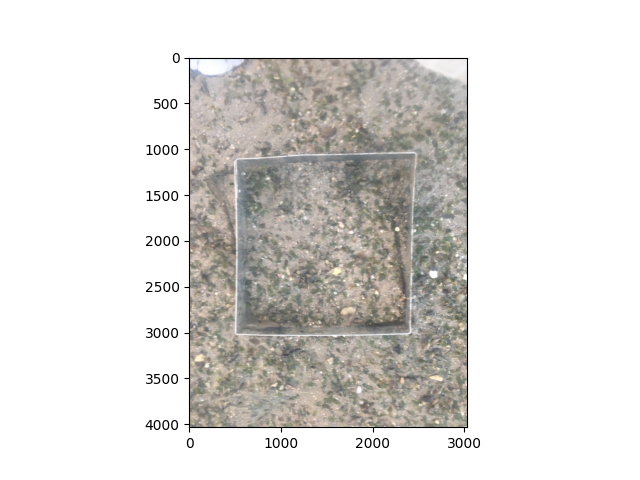

In [6]:
plt.imshow(I_RGB);

One of the goals was to "count" the amount of seagrass in each photo. Let's simplify things, and assume that all the GREEN portions are seagrass. How can we do so with a computer? Perhaps we could break the problem down into a few steps:

1. Detect the bounding box and crop out the remaining portion of the image.
2. Keep only the pixels that fall in the GREEN portion of the colour spectrum.
3. Count those pixels.

## Histogram Equalisation

As we can see, some of the images are bright and some are darker. Equalising the histogram will make it easier to detect edges and boundaries later on. What do we mean by equalising the histogram? First, we convert the RGB colorspace into the HSV (Hue, Saturation and Value) colorspace ([details](https://docs.opencv.org/4.5.3/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv)). In this space, the "color" is represented by hue, just a single coordinate. The Value represents the intensity.

In [7]:
I = cv.imread(str(p / 'R06.JPG'))
I_RGB = cv.cvtColor(I, cv.COLOR_BGR2RGB)
I_HSV = cv.cvtColor(I, cv.COLOR_BGR2HSV)

In [8]:
I_HSV_equal = np.copy(I_HSV)

In [9]:
I_HSV_equal[:, :, 2] = cv.equalizeHist(I_HSV[:, :, 2])
I_RGB_equal = cv.cvtColor(I_HSV_equal, cv.COLOR_HSV2RGB)

In [10]:
%matplotlib inline

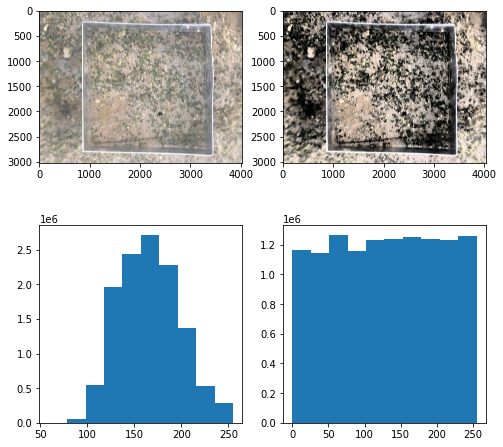

In [11]:
plt.figure(figsize=(8, 8))
plt.subplot(221); #plt.subplot(2,2,1)
plt.imshow(I_RGB);
plt.subplot(222); #plt.subplot(2,2,2)
plt.imshow(I_RGB_equal);
plt.subplot(223)
plt.hist(I_HSV[:, :, 2].ravel());
plt.subplot(224)
plt.hist(I_HSV_equal[..., 2].ravel());

## Thresholding

Thresholding is a routine operation in image processing - it means that we only keep the pixels that satisy a certain criteria. The rest are zero-ed out. For instance, we may wish to keep only those pixels that fall within the bounding box of an object that we have detected, or only those that are a certain shade of GREEN.

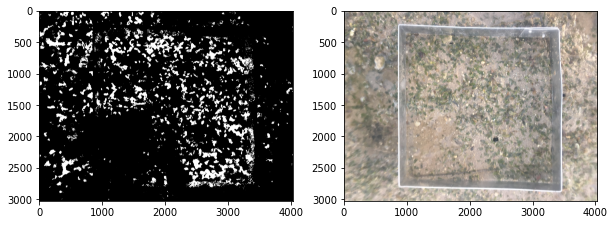

In [12]:
# define range of green color in HSV
lower_green = np.array([ 30,   0,  0])
upper_green = np.array([ 90, 255, 90])

# Threshold the HSV image to get only green colors
mask_hsv = cv.inRange(I_HSV_equal, lower_green, upper_green)
plt.figure(figsize=(10, 5))
plt.subplot(121);
plt.imshow(mask_hsv, cmap='gray');
plt.subplot(122);
plt.imshow(I_RGB);

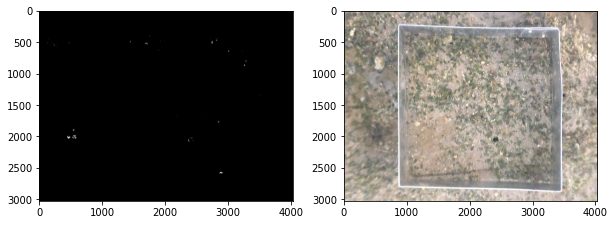

In [13]:
# define range of green color in HSV
lower_green = np.array([ 30,   0,  0])
upper_green = np.array([ 90, 255, 90])

# Threshold the HSV image to get only green colors
mask_hsv = cv.inRange(I_HSV, lower_green, upper_green)
plt.figure(figsize=(10, 5))
plt.subplot(121);
plt.imshow(mask_hsv, cmap='gray');
plt.subplot(122);
plt.imshow(I_RGB);

## Edge Detection

In this application, we wish to detect the boundary of the rectangular mesh automatically. There are numerous algorithms for detecting edges, but most of them have to do with detecting sharp changes in the gradient of the intensity. One of the commonly used ones is [Harris Edge and Corner detection](https://docs.opencv.org/master/dc/d0d/tutorial_py_features_harris.html).

In [23]:
I_GRAY = cv.cvtColor(I_RGB_equal, cv.COLOR_RGB2GRAY)
I_gray_32 = np.float32(I_GRAY)
# Input single-channel 8-bit or floating-point image
dst = cv.cornerHarris(I_gray_32, 10, 3, 0.1)

In [24]:
# When R < 0, which happens when λ1 >> λ2 or vice versa, the region is edge
retval, out_img = cv.threshold(dst, 0, 255, cv.THRESH_BINARY_INV)

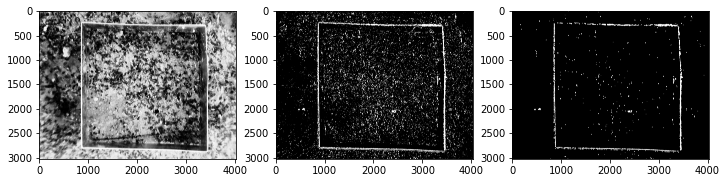

In [25]:
kernel = np.ones((3, 3), np.uint8)
edges2 = cv.morphologyEx(out_img, cv.MORPH_OPEN, kernel, iterations=5)

plt.figure(figsize=(12, 4))
plt.subplot(131);
plt.imshow(I_GRAY, cmap='gray');
plt.subplot(132);
plt.imshow(out_img, cmap='gray');
plt.subplot(133);
plt.imshow(edges2, cmap='gray');

In [17]:
%matplotlib widget

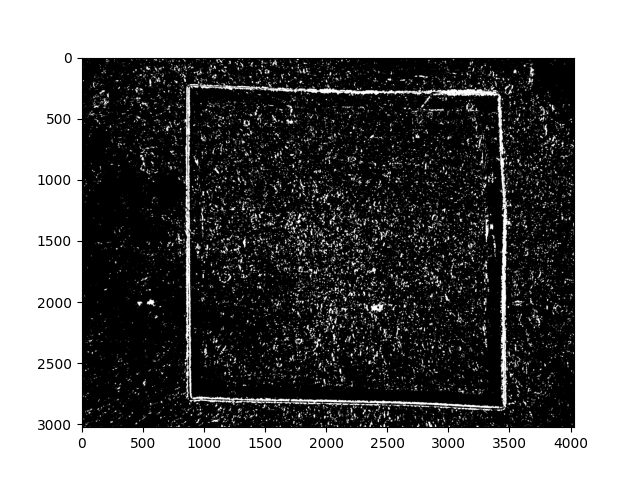

In [18]:
plt.imshow(out_img, cmap='gray');

After the edge detection, we performed an "opening" to get rid of small specks and attempted to magnify the line thickness.

<img src="../figs/morph_open.png" width=200>

The opposite of "opening" is closing a figure:

<img src="../figs/morph_close.png" width=200>

## Augmentation 

As we proceed, most of the models we use are going to be trained on huge datasets. Remember that the more examples a model sees during its training phase, the better it can learn and generalise. However, it is just not possible to collect all possible samples of images. Imagine if we are training a model to detect cats - could we get all images of all breeds of cats in all poses at all possible angles at all possible resolutions?

To get around this, we can augment our training set with variations of our original training images. Many deep learning packages/frameworks already contain such functions (see keras, tensorflow, for instance). We shall use a dedicated package for it, so that we do not have to learn about dataset loaders etc. from those packages.

Suppose we wish to generate variations of the following image:

In [22]:
%matplotlib inline

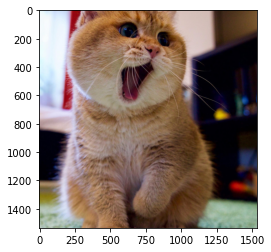

In [26]:
hosi = cv.imread('../data/hosico_cat.jpg')
hosi = cv.cvtColor(hosi, cv.COLOR_BGR2RGB)
plt.imshow(hosi);

In [27]:
from imgaug import augmenters as iaa

In [28]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)
#images_aug = seq(image=im_me)

In [29]:
hosi_list = [hosi, hosi, hosi, hosi, hosi]
images_aug = seq(images=hosi_list)

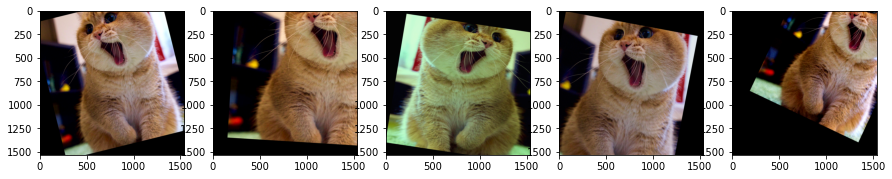

In [30]:
plt.figure(figsize=(15, 5))
for ii in np.arange(5):
    plt.subplot(1, 5, ii+1)
    plt.imshow(images_aug[ii])

<a id='obj-det'></a>
# 3. Object Detection
<a href=#top>(back to top)</a>

Object detection is done by training deep learning models to detect pre-specified categories of objects. The models use different strategies, and the particular architecture they use for the deep learning  model reflects this.

For instance, single-shot detectors use a strategy where they generate multiple "anchor" boxes and predict the object categories within them. After that, boxes are combined if they refer to the same object, or dropped if they correspond to "background".

<img src="../figs/ssd.svg" width=450>

Region-based models search for 'interesting regions' instead of brute forcing multiple anchor boxes.

<img src="../figs/r-cnn.svg" width=450>

A very popular object detection model is called YOLO (You only look once). Let us try it out here.

# OpenCV Model Zoo

The opencv library comes with a `dnn` module that contains several pre-trained deep learning models. Here is how we can inspect them and download them. The files and information come from two different git repositories:

1. The [opencv_extra](https://github.com/opencv/opencv_extra) repository. (Download the zip file and unzip it on your laptop). This folder contains
    * `testdata/dnn/download_models.py`, which can be used to download the configuration file and weights file 
    for a particular pre-trained model. This file is included as is in the `scripts` module. 
1. The main [opencv](https://github.com/opencv/opencv) repository. (Download the zip file and unzip it on your laptop).
    * Under the `samples/dnn` folder are several example Python scripts that you can use to run these models.
    * One of these files is `samples/dnn/models.yml`. It contains some specifications of the model parameters. These parameters need to be included when calling one of the sample scripts, for instance
    `samples/dnn/object_detection.py`. This `models.yml` file is the model zoo. It also contains specifications such as image size, and whether the image needs to be in RGB specification.
    * Another set of files are contained in `samples/data/dnn`. These txt files contain the possible prediction classes for some of the object detection models.
    
It is best if you clone those two repositories onto your computer, but let's see if we can get by without doing that. Here are the relevant files that have been copied for you into the `python_notebooks/` folder:

1. `models.yml`
2. `classification_classes_ILSVRC2012.txt`
3. `object_detection_classes_yolov3.txt`

Remember that we wished to download the YOLOv3 weights. We are going to download the configuration file and the weights using the download_models module that we have copied into scripts. 

In [31]:
import scripts.download_models as dm

These are all possible models we can download and (theoretically) apply.

In [32]:
model_names = [x.name for x in dm.models]
print('\n'.join(model_names))

GoogleNet
Alexnet
Inception
Enet
Fcn
Ssd_vgg16
ResNet50
SqueezeNet_v1.1
MobileNet-SSD
MobileNet-SSD
OpenFace
YoloV2voc
TinyYoloV2voc
DenseNet-121
DenseNet-121
Fast-Neural-Style
Fast-Neural-Style
MobileNet-SSD (TensorFlow)
MobileNet-SSD (TensorFlow)
MobileNet-SSD v1 (TensorFlow)
MobileNet-SSD v1 (TensorFlow)
MobileNet-SSD v2 (TensorFlow)
MobileNet-SSD v2 (TensorFlow)
Colorization
Colorization
Face_detector
Face_detector (FP16)
Face_detector (UINT8)
InceptionV2-SSD (TensorFlow)
InceptionV2-SSD (TensorFlow)
Faster-RCNN
Faster-RCNN VGG16
Faster-RCNN ZF
R-FCN
R-FCN ResNet-50
OpenPose/pose/coco
OpenPose/pose/mpi
YOLOv3
EAST
EAST
Faster-RCNN, InveptionV2 (TensorFlow)
Faster-RCNN, InveptionV2 (TensorFlow)
ssd_mobilenet_v1_ppn_coco (TensorFlow)
ssd_mobilenet_v1_ppn_coco (TensorFlow)
mask_rcnn_inception_v2_coco_2018_01_28 (TensorFlow)
mask_rcnn_inception_v2_coco_2018_01_28 (TensorFlow)
faster_rcnn_resnet50_coco (TensorFlow)
faster_rcnn_resnet50_coco (TensorFlow)
AlexNet (ONNX)
AlexNet (ONNX)
Goo

In [33]:
# For object detection
yolo3mod = [x for x in dm.models if x.name.startswith('YOLOv3')][0]

# For image classification
googlenetmod = [x for x in dm.models if x.name.startswith('GoogleNet')][0]

In [ ]:
#googlenetmod.get()

In [ ]:
#yolo3mod.get()

Let us take a closer look at the specification of YOLO version 3.

In [35]:
#!grep "YOLO" -A 10 models.yml
!findstr /n YOLO models.yml

18:# YOLO object detection family from Darknet (https://pjreddie.com/darknet/yolo/)
19:# Might be used for all YOLOv2, TinyYolov2 and YOLOv3


In [36]:
print(*open('models.yml').readlines()[17:29], sep="")

# YOLO object detection family from Darknet (https://pjreddie.com/darknet/yolo/)
# Might be used for all YOLOv2, TinyYolov2 and YOLOv3
yolo:
  model: "yolov3.weights"
  config: "yolov3.cfg"
  mean: [0, 0, 0]
  scale: 0.00392
  width: 416
  height: 416
  rgb: true
  classes: "object_detection_classes_yolov3.txt"
  sample: "object_detection"



It expects the input images to have dimensions (416, 416), that the pixels be in  RGB format, but scaled by 0.00392, and no mean centering. The categories of objects that it can pick up are in the file `object_detection_classes_yolov3.txt`. 

In [37]:
#!grep "googlenet" -I -A 10 models.yml
!findstr /n googlenet models.yml

93:# Googlenet from https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet
94:googlenet:
95:  model: "bvlc_googlenet.caffemodel"
96:  config: "bvlc_googlenet.prototxt"


In [38]:
print(*open('models.yml').readlines()[92:103], sep="")

# Googlenet from https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet
googlenet:
  model: "bvlc_googlenet.caffemodel"
  config: "bvlc_googlenet.prototxt"
  mean: [104, 117, 123]
  scale: 1.0
  width: 224
  height: 224
  rgb: false
  classes: "classification_classes_ILSVRC2012.txt"
  sample: "classification"



In contrast, the GoogLeNet model requires images to be of size (224, 224), to be in BGR format, and to be mean centred. The categories that it predicts from are listed in `classification_classes_ILSVRC2012.txt`.

Now let us inspect **how** to run object detection using the sample script from opencv.

In [1]:
%run opencv-master/samples/dnn/object_detection.py --help

Exception: File `'opencv-master/samples/dnn/object_detection.py'` not found.

Before you run the next command, take note of the following. The opencv GUI window management is a little fragile. When you are done with it, **do not** click on the "X" at the top to close the window. Instead, press "q" on your keyboard. That would stop the process in the background. Then, return to the jupyter notebook and run this command:

In [48]:
cv.destroyAllWindows()

*If you click on the "X", you will end up having to restart your kernel.*

In [40]:
%run opencv-master/samples/dnn/object_detection.py --input ../data/cars.jpg --model yolov3.weights \
--config yolov3.cfg --scale 0.00392 --width 416 --height 416 --rgb \
--classes object_detection_classes_yolov3.txt yolo

c:\users\stalimtw\opencv\lib\site-packages\numpy\lib\function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


In [42]:
%run opencv-master/samples/dnn/object_detection.py --input ../data/2018-07-18-1350.jpg --model yolov3.weights \
--config yolov3.cfg --scale 0.00392 --width 416 --height 416 --rgb \
--classes object_detection_classes_yolov3.txt yolo

Now try any image that you have on your laptop or phone. When you are done, you can even use the camera on your laptop to detect things in realtime:

In [44]:
%run opencv-master/samples/dnn/object_detection.py --model yolov3.weights \
--config yolov3.cfg --scale 0.00392 --width 416 --height 416 --rgb \
--classes object_detection_classes_yolov3.txt yolo

In [46]:
%run opencv-master/samples/dnn/classification.py --help

usage: classification.py [-h] [--zoo ZOO] [--input INPUT] [--framework {caffe,tensorflow,torch,darknet}]
                         [--std [STD ...]] [--crop CROP] [--initial_width INITIAL_WIDTH]
                         [--initial_height INITIAL_HEIGHT] [--backend {0,1,2,3,4,5}] [--target {0,1,2,3,8,4,6,7}]
                         --model MODEL [--config CONFIG] [--mean MEAN [MEAN ...]] [--scale SCALE] [--width WIDTH]
                         [--height HEIGHT] [--rgb] [--classes CLASSES]
                         [{squeezenet,googlenet}]

Use this script to run classification deep learning networks using OpenCV.

positional arguments:
  {squeezenet,googlenet}
                        An alias name of model to extract preprocessing parameters from models.yml file. (default:
                        None)

optional arguments:
  -h, --help            show this help message and exit
  --zoo ZOO             An optional path to file with preprocessing parameters. (default:
                     

In [47]:
%run opencv-master/samples/dnn/classification.py --input ../data/cars.jpg \
--model bvlc_googlenet.caffemodel --config bvlc_googlenet.prototxt \
--scale 1.00 --width 224 --height 224 --mean 104 117 123 \
--classes classification_classes_ILSVRC2012.txt googlenet

## Running Detections Programmatically

Instead of running things from the command line, sometimes we need to run the detection through a program. We need to figure out how the `object_detection.py` works. This is a common experience in data science - having to read and understand someone else's code, and to then hack it to do what we need. 

Here's how we can step through the function.

In [ ]:
%run opencv-master/samples/dnn/object_detection.py --input ../data/cars.jpg --model yolov3.weights \
--config yolov3.cfg --scale 0.00392 --width 416 --height 416 --rgb \
--classes object_detection_classes_yolov3.txt yolo

Once we have done that, we can identify the main steps in the program as :
1. instantiate the dnn object
2. convert the image to a blob
3. run the postprocess() function.

In [ ]:
import scripts.vision as vs

In [ ]:
# object_detection.py line 89
nn = cv.dnn.readNet('yolov3.weights', 'yolov3.cfg')
# object_detection.py line 85
with open('opencv-master/samples/data/dnn/object_detection_classes_yolov3.txt', 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [ ]:
f1 = cv.imread('../data/football1.png')
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(f1, cv.COLOR_BGR2RGB));

In [ ]:
# object_detection.py lines 272, 279, 284(92)
blob = cv.dnn.blobFromImage(f1, size=(416, 416), swapRB=True, ddepth=cv.CV_8U)
nn.setInput(blob, scalefactor=0.00392 )
outs = nn.forward(nn.getUnconnectedOutLayersNames())

In [ ]:
vs.postprocess(f1, outs, classes, nn)

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(f1, cv.COLOR_BGR2RGB));

# Changing perspective of an image

In computer vision, we have to remember that we are projecting a 3-dimensional world onto a 2-D plane. At times, we need to change the perspective of a plane in order to compute coordinates correctly. If we can identify a mapping of 4 points from the plane we want onto the view we desire, then we can do so. Consider obtaining a top-down view of the field from the above image.

In [ ]:
img = cv.imread('../data/football1.png')
pts = np.array([[45, 121], [48, 238], [206, 230], [155, 119]], np.int32)
pts = pts.reshape((-1, 1, 2))
img2 = cv.polylines(img, [pts], True, (255, 0, 0), 1 )
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB));

We know that the blue polygon above should map to a rectangle in the top-down view, with the **ellipse as a circle**. So with a little trial and error, we can obtain this:

In [ ]:
pts1 = np.float32([[45, 121], [48, 238], [206, 230], [155, 118]])
#pts2 = np.float32([[45, 100], [45, 220], [200, 220], [200, 100]])
pts2 = np.float32([[45, 100], [45, 220], [77, 220], [77, 100]])

M = cv.getPerspectiveTransform(pts1, pts2)
dst = cv.warpPerspective(img, M, (504, 360))

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(dst[:, :300], cv.COLOR_BGR2RGB));

<a id='ref'></a>
# 4. References
<a href=#top>(back to top)</a>

1. A classic [reference](http://szeliski.org/Book/) on computer vision.
2. The opencv [website](https://docs.opencv.org/master/index.html) contains tutorials on the package.
3. An alternative to opencv is [gluon-cv](https://gluon-cv.mxnet.io/).
4. An [online textbook](https://d2l.ai/index.html) on deep learning, with examples in mxnet and pytorch, written by Amazon researchers. It is used in a course at Berkeley. It has a big chapter on deep learning in computer vision.